In [4]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from copy import deepcopy

import time

# Generate data

In [5]:
# iid (Possibly intersting)
X = rnd_gen.normal(loc=0, scale=1, size=(2000, 4))
# beta = np.array([2, 1, 0, 0])
# Y = X @ beta + rnd_gen.normal(loc=0, scale=1, size=2000)

# # Change points
# beta1 = np.array([2, 1, 0, 0])
# beta2 = np.array([0, -2,-1, 0])
# beta3 = np.array([0, 0, 2, 1])

# Y1 = X[:500] @ beta1 + rnd_gen.normal(loc=0, scale=1, size=500)
# Y2 = X[500:1500] @ beta2 + rnd_gen.normal(loc=0, scale=1, size=1000)
# Y3 = X[1500:] @ beta3 + rnd_gen.normal(loc=0, scale=1, size=500)
# Y = np.concatenate([Y1, Y2, Y3])

# Drift
beta1 = np.array([2, 1, 0, 0])
betaN = np.array([0, 0, 2, 1])
Y = np.zeros((X.shape[0]))
for i, x in enumerate(X):
    Y[i] = x @ ((1 - i/(X.shape[0]-1))*beta1 + (i/(X.shape[0]-1))*betaN) + rnd_gen.normal(loc=0, scale=1)

In [6]:
initial_training_size = 100
X_train = X[:initial_training_size]
y_train = Y[:initial_training_size]

X_run = X[initial_training_size:]
y_run = Y[initial_training_size:]

epsilon = 0.1
gamma = 0.005

In [7]:
from CRR import ConformalRidgeRegressor
cp = ConformalRidgeRegressor(a=0)

time_init_cp = time.time()
cp.learn_initial_training_set(X_train, y_train)

Err_cp = 0

eps = epsilon

predictions_cp = np.empty((X_run.shape[0], 5))
for i, (obj, label) in tqdm(enumerate(zip(X_run, y_run)), total=y_run.shape[0]):
    # Reality presents the object x
    x = obj
    # Forecaster outputs Gamma
    Gamma, precomputed = cp.predict(x, epsilon=eps, bounds='both', return_update=True)
    width = cp.width(Gamma)
    # Reality presents the label
    y = label
    cp.learn_one(x, y, precomputed)
    err = cp.err(Gamma, label)

    eps += gamma*(epsilon - err)
    eps = max(2/cp.X.shape[0], eps)

    Err_cp += err
    predictions_cp[i, 0] = Gamma[0] # Lower 
    predictions_cp[i, 1] = Gamma[1] # Upper 
    predictions_cp[i, 2] = err # Error
    predictions_cp[i, 3] = eps # True label
    predictions_cp[i, 4] = width # True label
time_cp = time.time() - time_init_cp

  0%|          | 0/1900 [00:00<?, ?it/s]

In [8]:
from Ridge_point_predictor import OnlineRidgeRegressor

ols = OnlineRidgeRegressor(a=0)

time_init_ols = time.time()

ols.learn_initial_training_set(X_train, y_train)

Err_ols = 0

eps = epsilon

predictions_ols = np.empty((X_run.shape[0], 5))
for i, (obj, label) in tqdm(enumerate(zip(X_run, y_run)), total=y_run.shape[0]):
    # Reality presents the object x
    x = obj
    Gamma = ols.predict_interval(x, epsilon=eps)
    width = ols.width(Gamma)
    # Reality reveals y
    y = label
    ols.learn_one(x, y)
    err = ols.err(Gamma, label)

    eps += gamma*(epsilon - err)
    eps = max(2/ols.X.shape[0], eps)

    Err_ols += err
    predictions_ols[i, 0] = Gamma[0] # Lower 
    predictions_ols[i, 1] = Gamma[1] # Upper 
    predictions_ols[i, 2] = err # Error
    predictions_ols[i, 3] = label # True label
    predictions_ols[i, 4] = width # True label
time_ols = time.time() - time_init_ols

  0%|          | 0/1900 [00:00<?, ?it/s]

In [9]:
from Ridge_point_predictor import RidgeICP

cal_frac = 1/3
icp = RidgeICP(0)

time_init_icp_retrain = time.time()

X_train_icp_retrain = deepcopy(X_train)
y_train_icp_retrain = deepcopy(y_train)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train_icp_retrain, y_train_icp_retrain, test_size=cal_frac, random_state=2024)

icp.fit(X_prop_train, y_prop_train)
icp.calibrate(X_cal, y_cal)

Err_icp_retrain = 0

eps = epsilon

predictions_icp_retrain = np.empty((X_run.shape[0], 5))
for i, (obj, label) in tqdm(enumerate(zip(X_run, y_run)), total=y_run.shape[0]):
    # Reality presents the object x
    x = obj
    Gamma = icp.predict_interval(x, epsilon=eps)
    width = icp.width(Gamma)
    # Reality reveals y
    y = label

    # Retrain ICP
    X_train_icp_retrain = np.append(X_train_icp_retrain, x.reshape(1, -1), axis=0)
    y_train_icp_retrain = np.append(y_train_icp_retrain, y)

    X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train_icp_retrain, y_train_icp_retrain, test_size=cal_frac, random_state=2024)

    icp.fit(X_prop_train, y_prop_train)
    icp.calibrate(X_cal, y_cal)

    err = icp.err(Gamma, label)

    eps += gamma*(epsilon - err)
    eps = max(2/icp.h, eps)

    Err_icp_retrain += err
    predictions_icp_retrain[i, 0] = Gamma[0] # Lower 
    predictions_icp_retrain[i, 1] = Gamma[1] # Upper 
    predictions_icp_retrain[i, 2] = err # Error
    predictions_icp_retrain[i, 3] = label # True label
    predictions_icp_retrain[i, 4] = width # True label
time_init_icp_retrain = time.time() - time_init_icp_retrain

  0%|          | 0/1900 [00:00<?, ?it/s]

In [10]:
# cal_frac = 1/3
# icp = RidgeICP(0)

# X_train_icp = deepcopy(X_train)
# y_train_icp = deepcopy(y_train)

# X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train_icp, y_train_icp, test_size=cal_frac, random_state=2024)

# icp.fit(X_prop_train, y_prop_train)
# icp.calibrate(X_cal, y_cal)

# Err_icp = 0

# eps = epsilon

# predictions_icp = np.empty((X_run.shape[0], 5))
# for i, (obj, label) in tqdm(enumerate(zip(X_run, y_run)), total=y_run.shape[0]):
#     # Reality presents the object x
#     x = obj
#     Gamma = icp.predict_interval(x, epsilon=eps)
#     width = icp.width(Gamma)
#     # Reality reveals y
#     y = label

#     # Retrain ICP
#     X_cal = np.append(X_cal, x.reshape(1, -1), axis=0)
#     y_cal = np.append(y_cal, y)

#     icp.calibrate(X_cal, y_cal)

#     err = icp.err(Gamma, label)

#     eps += gamma*(epsilon - err)
#     eps = max(2/icp.h, eps)

#     Err_icp += err
#     predictions_icp[i, 0] = Gamma[0] # Lower 
#     predictions_icp[i, 1] = Gamma[1] # Upper 
#     predictions_icp[i, 2] = err # Error
#     predictions_icp[i, 3] = label # True label
#     predictions_icp[i, 4] = width # True label

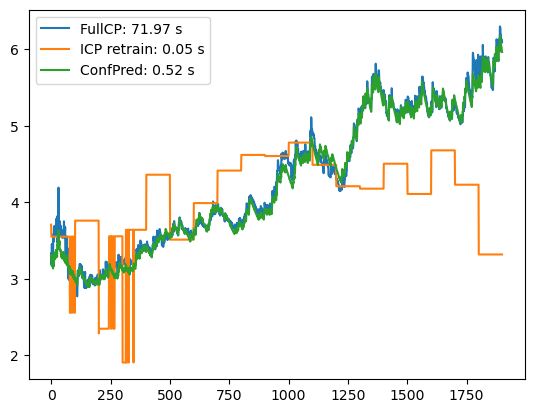

In [11]:
plt.plot(predictions_cp[:, 4], label=f'FullCP: {time_cp:,.2f} s')
plt.plot(predictions_icp_retrain[:, 4], label=f'ICP retrain: {time_init_icp_retrain:,.2f} s')
plt.plot(predictions_ols[:, 4], label=f'ConfPred: {time_ols:,.2f} s')

# plt.plot(predictions_icp[:, 4], label='ICP fixed')
plt.legend()

Text(0.5, 1.0, 'Coverage: 0.2289')

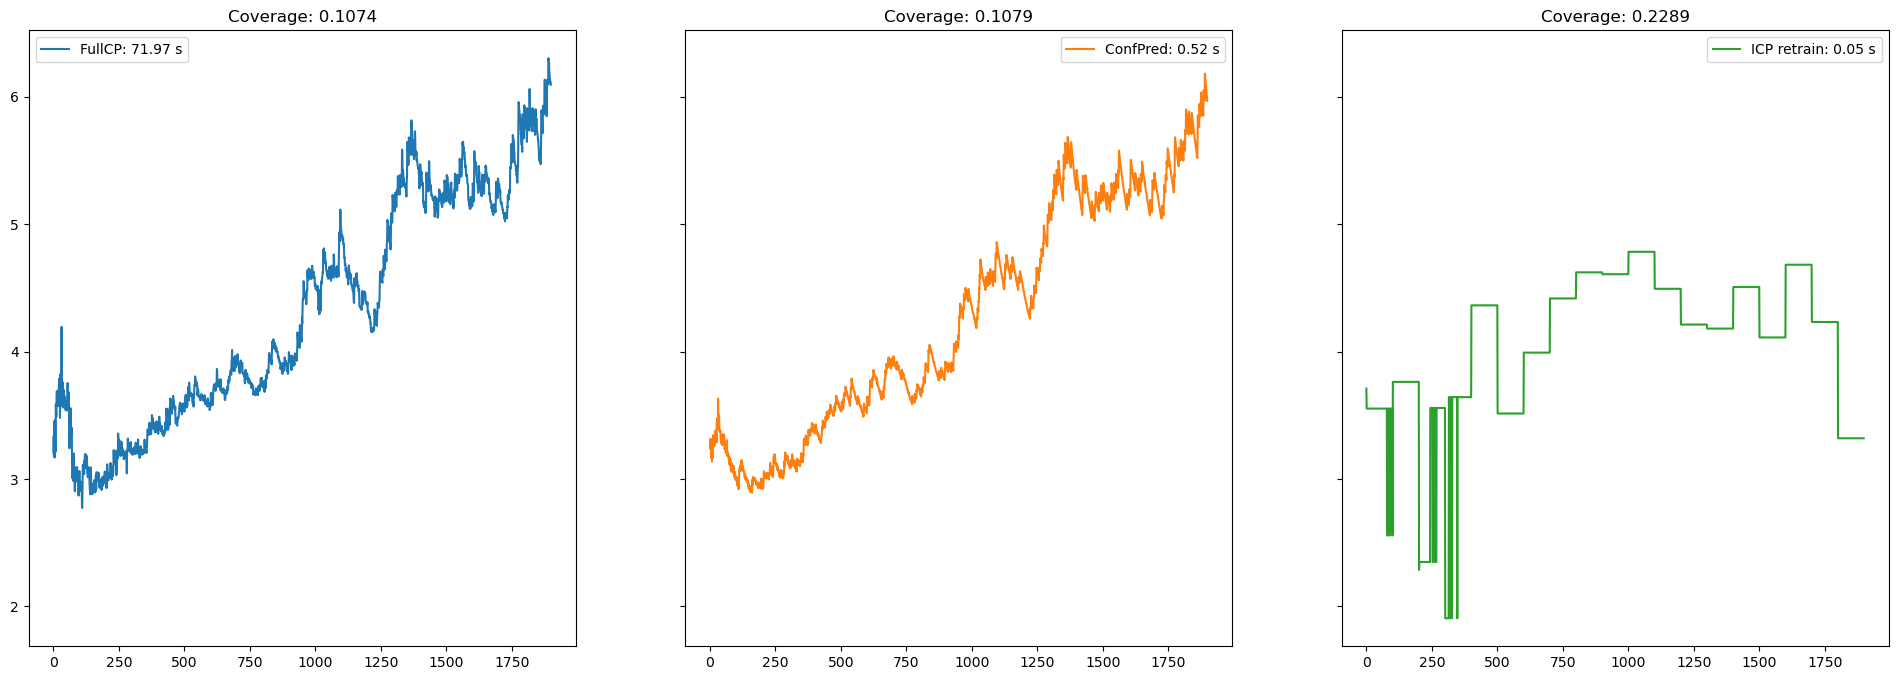

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), sharey=True)
axs[0].plot(predictions_cp[:, 4], label=f'FullCP: {time_cp:,.2f} s', color='C0')
axs[0].legend()
axs[0].set_title(f'Coverage: {Err_cp / X_run.shape[0]:,.4f}')

axs[1].plot(predictions_ols[:, 4], label=f'ConfPred: {time_ols:,.2f} s', color='C1')
axs[1].legend()
axs[1].set_title(f'Coverage: {Err_ols / X_run.shape[0]:,.4f}')

axs[2].plot(predictions_icp_retrain[:, 4], label=f'ICP retrain: {time_init_icp_retrain:,.2f} s', color='C2')
axs[2].legend()
axs[2].set_title(f'Coverage: {Err_icp_retrain / X_run.shape[0]:,.4f}')



In [13]:
predictions_cp[:, 4].mean(), predictions_ols[:, 4].mean(), predictions_icp_retrain[:, 4].mean()#, predictions_icp[:, 4].mean()

(4.313134687925933, 4.273193917905682, 4.079771777508526)

In [14]:
Err_cp / X_run.shape[0], Err_ols / X_run.shape[0], Err_icp_retrain / X_run.shape[0]#, Err_icp / X_run.shape[0]

(0.10736842105263159, 0.10789473684210527, 0.22894736842105262)

# Conclusions
We should really try this with many different seeds and do some kind of statistical analysis on the width. Figure out a way to do that, or even better, figure out a way to do it on some good metric for prediction intervals.

It is quite obvious that just running ACI on the OLS predictor is A LOT faster, so if it is not significantly worse in terms of width, we have a winner!

# Future experiments
We need to test this on some real data. Full CP will not be particularly useful unless we use KNN, which can be done of course.

# Testing ConfidencePredictor

In [15]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=6)
# from Ridge_point_predictor import ConfidencePredictor

# icp = ConfidencePredictor(rf)

# X_train_icp_retrain = deepcopy(X_train)
# y_train_icp_retrain = deepcopy(y_train)


# icp.fit(X_train_icp_retrain, y_train_icp_retrain)

# Err_icp_retrain = 0

# eps = epsilon

# predictions_icp_retrain = np.empty((X_run.shape[0], 5))
# for i, (obj, label) in tqdm(enumerate(zip(X_run, y_run)), total=y_run.shape[0]):
#     # Reality presents the object x
#     x = obj
#     Gamma = icp.predict_interval(x, epsilon=eps)
#     width = icp.width(Gamma)
#     # Reality reveals y
#     y = label

#     # Retrain ICP
#     X_train_icp_retrain = np.append(X_train_icp_retrain, x.reshape(1, -1), axis=0)
#     y_train_icp_retrain = np.append(y_train_icp_retrain, y)

#     icp.fit(X_train_icp_retrain, y_train_icp_retrain)

#     err = icp.err(Gamma, label)

#     eps += gamma*(epsilon - err)
#     # eps = max(2/icp.h, eps)

#     Err_icp_retrain += err
#     predictions_icp_retrain[i, 0] = Gamma[0][0] # Lower 
#     predictions_icp_retrain[i, 1] = Gamma[1][0] # Upper 
#     predictions_icp_retrain[i, 2] = err # Error
#     predictions_icp_retrain[i, 3] = label # True label
#     predictions_icp_retrain[i, 4] = width[0] # True label

# We should test these three models statistically.
* Rerun with, say, 100 different seeds
* Save lots of statistics, but the important ones are empirical error and average width (Let's hope we don't have to deal with infinite intervals...)
* Formulate hypotheses: Something like "there is no difference in performance between these three models"
* Do a nice martingale test!

But let's start by just CP and OLS